## The purpose of this document is to build our first attempt at a VAR Model with the following steps

1. Differencing each feature then confirming stationarity using the Augmented Dickey-Fuller (ADF)
test.
2. Using Granger causality tests to identify predictors that “lag” GDP. Only these predictors will be
included in the initial VAR model.
3. Select order (p) of VAR model based on lowest AIC value.
4. Train VAR model of order (p). Experiment with different train test splits.
5. Check model residuals for serial correlation using Durbin Watson’s statistic. If serial correlation is
a problem, try making higher order VAR models or try adding more variables into the model.
6. Forecast GDP at different horizons.
7. Un-difference (inverse transform) the forecasted values to get the “real” forecast values in the
correct units.
8. Plot the forecast versus actual data for different time horizons and evaluate the forecast accuracy
using metrics such as: MSE, MAE, RMSE, MAPE, and R2.

**The above steps may need to be re-ordered based on the page we use to build the model (https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/#google_vignette)**.

Below are the libraries needed to run all the code.

In [111]:
#pip install statsmodels
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import numpy as np

"data" is a data frame that holds all of our financial data from 1976 to 2023. "dataM" includes the arithmetic and weighted average M-SCores, and only runs until 2013.

In [112]:
#The path depends on who is running the code
data = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\merged_data20231031125447.csv")
dataM = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\merged_data_mscore_wab20231031125447.csv")
#data = pd.read_csv(r"/Users/lukaszsledz/Documents/GaTech/MGT_6203/Project/Team-36/Data/merged_data20231031125447.csv")
#dataM = pd.read_csv(r"/Users/lukaszsledz/Documents/GaTech/MGT_6203/Project/Team-36/Data/merged_data_mscore_wab20231031125447.csv")
# data = pd.read_csv(r"C:\Users\Kerstin\Desktop\GT\6203\Project\merged_data20231031125447.csv")
# dataM = pd.read_csv(r"C:\Users\Kerstin\Desktop\GT\6203\Project\merged_data_mscore_wab20231031125447.csv")

In [113]:
display(data.head())
display(dataM.head())

,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,Quarter,indu return,indu return trend,indu velocity,indu acceleration,GDPC1,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,T10Y2Y acceleration
0,-0.001234,0.000012,0.000101,-0.000026,1976Q3,0.008929,-0.000165,0.000116,-0.000029,6012.356,63.4,63.333333,-0.30,0.350,1.22,1.289292,0.004792,-0.000260
1,0.005427,0.000090,-0.000076,-0.000062,1976Q4,0.017706,0.000179,-0.000052,-0.000025,6083.391,64.5,64.066667,0.45,-0.075,1.47,1.399542,0.001042,-0.000167
2,-0.001218,-0.000570,0.000076,0.000005,1977Q1,0.009097,-0.000502,0.000065,-0.000006,6201.659,66.6,66.866667,1.30,-0.325,1.41,1.292667,-0.002250,0.000115
3,0.003696,0.000019,-0.000013,-0.000050,1977Q2,0.015745,-0.000424,-0.000023,-0.000057,6313.559,65.5,65.933333,-1.45,0.300,1.12,1.036417,-0.007271,0.000135
4,0.007094,-0.000471,-0.000031,-0.000099,1977Q3,0.021129,-0.000702,-0.000023,-0.000107,6313.697,63.7,63.866667,0.05,0.675,0.59,0.627292,-0.005333,0.000406


,Quarter,Avg. M-Score,Weighted_M,Count,average M trend,average WM trend,average M velocity,average M acceleration,average WM velocity,average WM acceleration,...,WAB,average beta trend,average MCAP trend,WAB trend,average beta velocity,average beta acceleration,average MCAP velocity,average MCAP acceleration,WAB velocity,WAB acceleration
0,1977Q3,-2.892064,-3.602709,58,-2.908746,-2.908746,0.006076,-0.015328,0.006076,-0.015328,...,0.000188,0.588532,154317.129999,0.000188,0.006019,0.004604,-1099.740210,1090.703081,4.579012e-07,3.254375e-07
1,1977Q4,-2.905240,-3.580334,58,-2.853263,-2.853263,0.033571,0.005197,0.033571,0.005197,...,0.000191,0.619210,155068.429908,0.000190,0.006875,-0.004539,-1426.625694,-1090.236012,2.057119e-07,-4.117815e-07
2,1978Q1,-2.762485,-3.393768,58,-2.841604,-2.841604,0.016470,-0.022012,0.016470,-0.022012,...,0.000191,0.611632,156117.118476,0.000192,-0.010227,-0.000748,6049.221168,2017.425039,1.685134e-06,3.986992e-07
3,1978Q2,-2.857087,-3.376276,58,-2.820323,-2.820323,-0.010453,0.009112,-0.010453,0.009112,...,0.000195,0.598109,172566.120580,0.000195,0.000685,0.002822,4570.248510,78.710149,-1.510248e-07,-7.294480e-07
4,1978Q3,-2.841396,-3.284902,58,-2.862510,-2.862510,0.034694,0.049223,0.034694,0.049223,...,0.000192,0.668766,176864.664135,0.000191,0.067023,0.015320,-5607.083100,-2764.897303,-1.805289e-06,5.702326e-07


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sp500 return          187 non-null    float64
 1   sp500 return trend    187 non-null    float64
 2   sp500 velocity        187 non-null    float64
 3   sp500 acceleration    187 non-null    float64
 4   Quarter               187 non-null    object 
 5   indu return           187 non-null    float64
 6   indu return trend     187 non-null    float64
 7   indu velocity         187 non-null    float64
 8   indu acceleration     187 non-null    float64
 9   GDPC1                 187 non-null    float64
 10  WPSID62               187 non-null    float64
 11  WPSID62 trend         187 non-null    float64
 12  WPSID62 velocity      187 non-null    float64
 13  WPSID62 acceleration  187 non-null    float64
 14  T10Y2Y                187 non-null    float64
 15  T10Y2Y trend          1

In [115]:
dataM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Quarter                    141 non-null    object 
 1   Avg. M-Score               141 non-null    float64
 2   Weighted_M                 141 non-null    float64
 3   Count                      141 non-null    int64  
 4   average M trend            141 non-null    float64
 5   average WM trend           141 non-null    float64
 6   average M velocity         141 non-null    float64
 7   average M acceleration     141 non-null    float64
 8   average WM velocity        141 non-null    float64
 9   average WM acceleration    141 non-null    float64
 10  sp500 return               141 non-null    float64
 11  sp500 return trend         141 non-null    float64
 12  sp500 velocity             141 non-null    float64
 13  sp500 acceleration         141 non-null    float64

We convert the Quarter columns to time series objects to be able to make clearer plots of the data.

In [116]:
#convert the quarter column in both datasets to PeriodIndex type bc we want to study the data sets as time series data
q = pd.to_datetime(data.Quarter)
qM = pd.to_datetime(dataM.Quarter)

data["date"] = q
dataM["date"]=qM

In [117]:
data.columns

Index(['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration', 'Quarter', 'indu return', 'indu return trend',
       'indu velocity', 'indu acceleration', 'GDPC1', 'WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration', 'T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration', 'date'],
      dtype='object')

Plots of the S&P 500 data (returns/quarter, trend, velocity, and acceleration.)

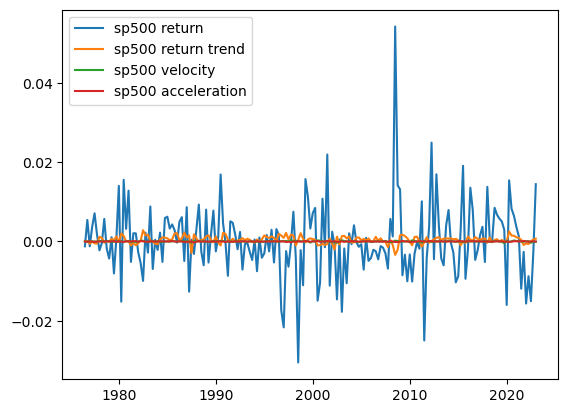

In [118]:
#sp500
plt.plot(data["date"], data[['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration']], label=['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration'])
plt.legend()

Plot of the INDU (Dow Jones?) return data (return, trend, velocity, and acceleration.)

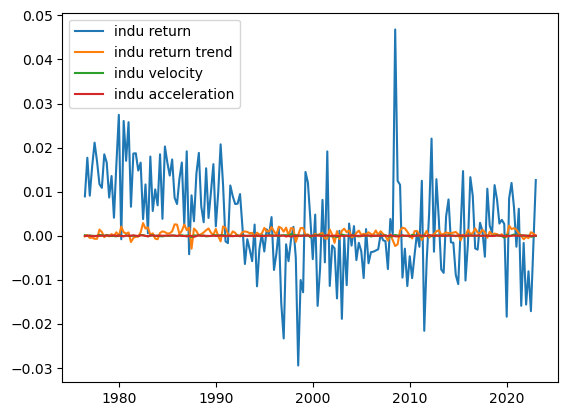

In [119]:
plt.plot(data["date"], data[['indu return', 'indu return trend',
       'indu velocity', 'indu acceleration']], label=['indu return', 'indu return trend',
       'indu velocity', 'indu acceleration'])
plt.legend()



PLot of WPSID62 (?) data (trend, velocity, and acceleration.)

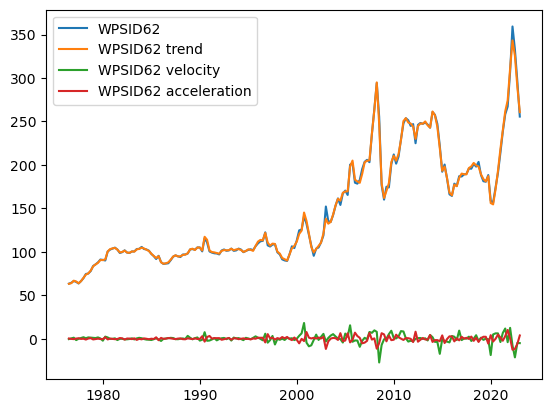

In [120]:
plt.plot(data["date"], data[['WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration']], label=['WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration'])
plt.legend()


Plot of yield curve data (yield curve, trend, velocity, and acceleration.)

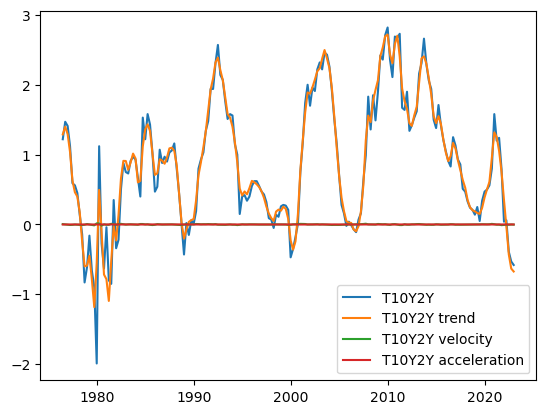

In [121]:
plt.plot(data["date"], data[['T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration']], label=['T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration'])
plt.legend()

PLot of real GDP. Note the massive dip in 2020. This is a problem when we run Granger Causality tests later.

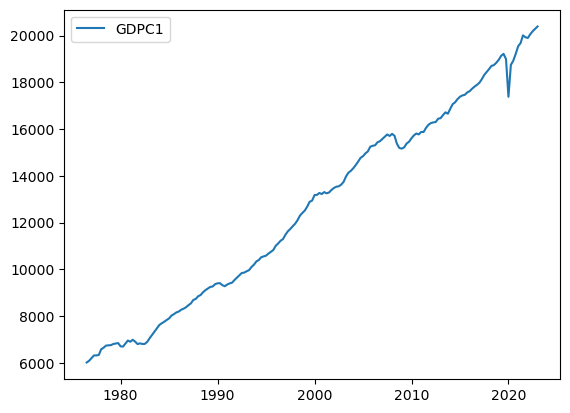

In [122]:
plt.plot(data["date"], data['GDPC1'], label='GDPC1')
plt.legend()

In [123]:
dataM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Quarter                    141 non-null    object        
 1   Avg. M-Score               141 non-null    float64       
 2   Weighted_M                 141 non-null    float64       
 3   Count                      141 non-null    int64         
 4   average M trend            141 non-null    float64       
 5   average WM trend           141 non-null    float64       
 6   average M velocity         141 non-null    float64       
 7   average M acceleration     141 non-null    float64       
 8   average WM velocity        141 non-null    float64       
 9   average WM acceleration    141 non-null    float64       
 10  sp500 return               141 non-null    float64       
 11  sp500 return trend         141 non-null    float64       
 12  sp500 ve

In [124]:
dataM.columns

Index(['Quarter', 'Avg. M-Score', 'Weighted_M', 'Count', 'average M trend',
       'average WM trend', 'average M velocity', 'average M acceleration',
       'average WM velocity', 'average WM acceleration', 'sp500 return',
       'sp500 return trend', 'sp500 velocity', 'sp500 acceleration',
       'indu return', 'indu return trend', 'indu velocity',
       'indu acceleration', 'GDPC1', 'WPSID62', 'WPSID62 trend',
       'WPSID62 velocity', 'WPSID62 acceleration', 'T10Y2Y', 'T10Y2Y trend',
       'T10Y2Y velocity', 'T10Y2Y acceleration', 'average beta',
       'average MCAP', 'WAB', 'average beta trend', 'average MCAP trend',
       'WAB trend', 'average beta velocity', 'average beta acceleration',
       'average MCAP velocity', 'average MCAP acceleration', 'WAB velocity',
       'WAB acceleration', 'date'],
      dtype='object')

Plot of average and weighted average M-Score.

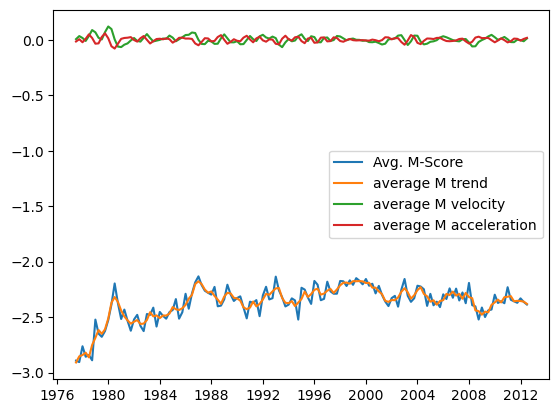

In [125]:
plt.plot(dataM["date"], dataM[['Avg. M-Score', 'average M trend', 'average M velocity', 'average M acceleration']], label=['Avg. M-Score', 'average M trend', 'average M velocity', 'average M acceleration'])
plt.legend()



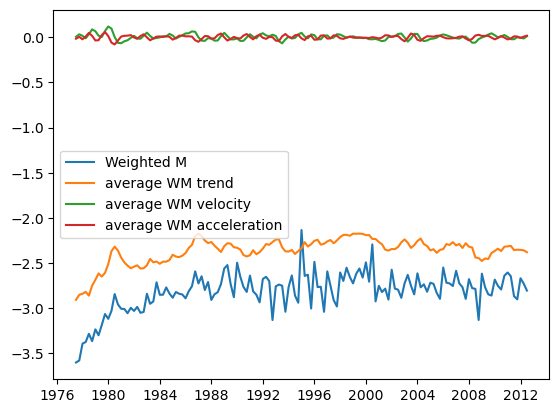

In [126]:
plt.plot(dataM["date"], dataM[['Weighted_M', 'average WM trend', 'average WM velocity', 'average WM acceleration']], label=['Weighted M', 'average WM trend', 'average WM velocity', 'average WM acceleration'])
plt.legend()



Plot of average beta (beta, trend, velocity, and acceleration.)

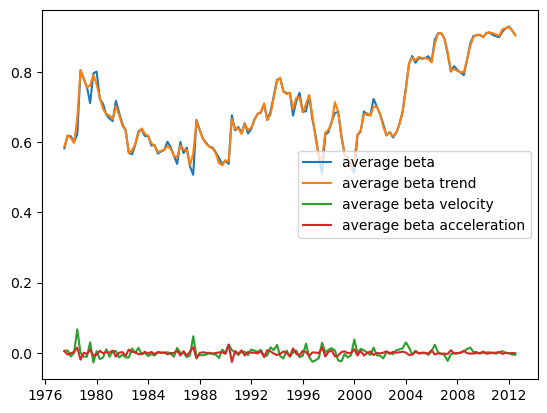

In [127]:
plt.plot(dataM["date"], dataM[['average beta','average beta trend','average beta velocity','average beta acceleration']], label=['average beta','average beta trend ','average beta velocity ','average beta acceleration'])
plt.legend()


Plot of weighted average beta (trend, velocity, and acceleration.)

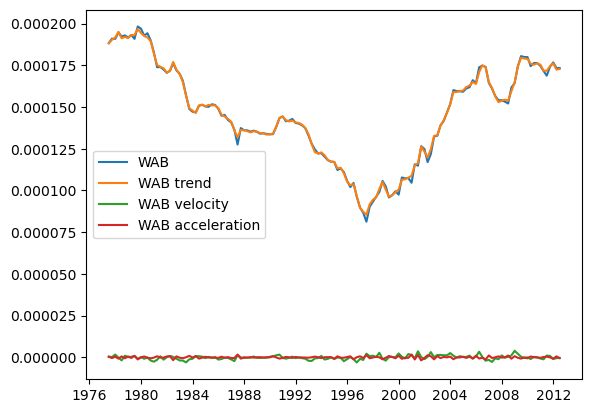

In [128]:
plt.plot(dataM["date"], dataM[['WAB','WAB trend','WAB velocity','WAB acceleration']], label=['WAB','WAB trend','WAB velocity ','WAB acceleration'])
plt.legend()


Plot of average market capitalization (trend, velocity, and acceleration.)

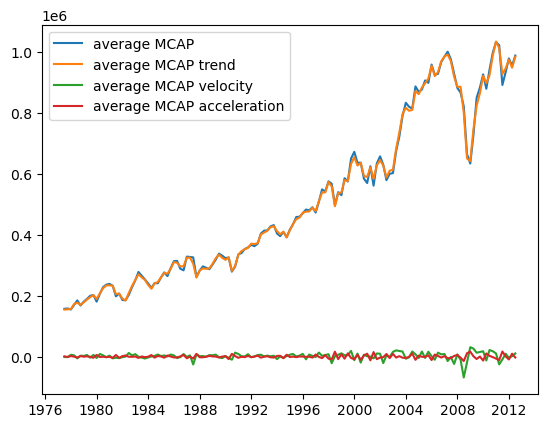

In [129]:
plt.plot(dataM["date"], dataM[['average MCAP','average MCAP trend','average MCAP velocity','average MCAP acceleration']], label=['average MCAP','average MCAP trend','average MCAP velocity','average MCAP acceleration'])
plt.legend()


In [130]:
data.columns

Index(['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration', 'Quarter', 'indu return', 'indu return trend',
       'indu velocity', 'indu acceleration', 'GDPC1', 'WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration', 'T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration', 'date'],
      dtype='object')

1) The below cells are running the Augmented Dickey-Fuller Test to check for stationary time series data. Granger Causality assumed that the data is stationary, so we need to make that true first

In [131]:
#ADF test for non-m-score data set
data_cols = data.loc[:,~data.columns.isin(["Quarter", "date"])].columns
data_adf = []
for i in data_cols:
    hold = adfuller(data[i])
    data_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_adf_df = pd.DataFrame(data_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

 In the 2023 data set, ndu return, GDPC1, WSPID62, WPSID62 trend, are all non-stationary, so they need to be differenced.

In [132]:
data_adf_df

,Column,Test Statistic,P-Value,Stationary?
0,sp500 return,-7.809705,7.123872e-12,True
1,sp500 return trend,-10.416515,1.748714e-18,True
2,sp500 velocity,-13.387918,4.831638e-25,True
3,sp500 acceleration,-13.587683,2.065296e-25,True
4,indu return,-2.435610,1.319368e-01,False
5,indu return trend,-10.729889,2.998611e-19,True
6,indu velocity,-13.754516,1.035629e-25,True
7,indu acceleration,-13.527539,2.660480e-25,True
8,GDPC1,0.706894,9.899745e-01,False
9,WPSID62,-0.420540,9.066125e-01,False


In [133]:
#ADF test for non-m-score data set
dataM_cols = dataM.loc[:,~dataM.columns.isin(["Quarter", "date", "Count"])].columns
dataM_adf = []
for i in dataM_cols:
    hold = adfuller(dataM[i])
    dataM_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

dataM_adf_df = pd.DataFrame(dataM_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

In the 2013 data set, we have the same results plus Avg. M Score, Avg. M trend, avg WM trend, indu return, GDP, PPI curve and its trend, average beta, average MCAP, WAB, average beta trend, average MCAP trend, WAB trend, and WAB velocity are also non-stationary. 

In [134]:
dataM_adf_df[dataM_adf_df["Stationary?"]==False]

,Column,Test Statistic,P-Value,Stationary?
0,Avg. M-Score,-1.850098,0.355888,False
2,average M trend,-2.657967,0.081598,False
3,average WM trend,-2.657967,0.081598,False
12,indu return,-2.096763,0.245818,False
16,GDPC1,0.237150,0.974270,False
17,WPSID62,1.177537,0.995827,False
18,WPSID62 trend,1.321250,0.996725,False
25,average beta,-1.824294,0.368469,False
26,average MCAP,-0.331603,0.920908,False
27,WAB,-2.544488,0.105022,False


Need to difference the non-stationary data to try to make them stationary. Differencing takes the difference with the previous row, or t-1. I first only looked at the columns that needed differencing.

In [135]:
list(data_adf_df[data_adf_df["Stationary?"] == False].Column)

['indu return', 'GDPC1', 'WPSID62', 'WPSID62 trend']

In [136]:
data_non_stat = data.loc[:,list(data_adf_df[data_adf_df["Stationary?"] == False].Column)]
dataM_non_stat = dataM.loc[:,list(dataM_adf_df[dataM_adf_df["Stationary?"] == False].Column)]

data_non_stat_trans = data_non_stat.diff().dropna()
dataM_non_stat_trans = dataM_non_stat.diff().dropna()

data_adf_trans = []
for i in data_non_stat_trans.columns:
    hold = adfuller(data_non_stat_trans[i])
    data_adf_trans.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_adf_trans_df = pd.DataFrame(data_adf_trans, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])


dataM_adf_trans = []
for i in dataM_non_stat_trans:
    hold = adfuller(dataM_non_stat_trans[i])
    dataM_adf_trans.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

dataM_adf_trans_df = pd.DataFrame(dataM_adf_trans, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

After differencing the data, everything is stationary.

In [137]:
display(data_adf_trans_df)
display(dataM_adf_trans_df)

,Column,Test Statistic,P-Value,Stationary?
0,indu return,-6.458333,1.464343e-08,True
1,GDPC1,-16.325114,3.100085e-29,True
2,WPSID62,-3.900012,2.034759e-03,True
3,WPSID62 trend,-3.991740,1.454385e-03,True


,Column,Test Statistic,P-Value,Stationary?
0,Avg. M-Score,-6.435763,1.654419e-08,True
1,average M trend,-4.764646,6.351923e-05,True
2,average WM trend,-4.764646,6.351923e-05,True
3,indu return,-5.360693,4.094283e-06,True
4,GDPC1,-5.348418,4.343106e-06,True
5,WPSID62,-2.953117,3.951073e-02,True
6,WPSID62 trend,-3.096629,2.680363e-02,True
7,average beta,-11.751335,1.207165e-21,True
8,average MCAP,-10.558160,7.853552e-19,True
9,WAB,-9.753674,7.892878e-17,True


From what I can tell, I need to diff the entire data in order to be consistent, and only then can I do granger causality. I created data frames data_diff and dataM_diff that hold the differenced data and then ran the test again, ending up with stationary data.

In [138]:

data_diff = data.drop(columns=["Quarter", "date"], axis=1).diff().dropna()
dataM_diff = dataM.drop(columns=["Quarter", "Count", "date"], axis=1).diff().dropna()

data_diff_adf = []
for i in data_cols:
    hold = adfuller(data_diff[i])
    data_diff_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_diff_adf_df = pd.DataFrame(data_diff_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])


dataM_diff_adf = []
for i in dataM_cols:
    hold = adfuller(dataM_diff[i])
    dataM_diff_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

dataM_diff_adf_df = pd.DataFrame(dataM_diff_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

display(data_diff_adf_df)
display(dataM_diff_adf_df)

,Column,Test Statistic,P-Value,Stationary?
0,sp500 return,-7.109053,3.982983e-10,True
1,sp500 return trend,-7.260385,1.687588e-10,True
2,sp500 velocity,-7.483142,4.714311e-11,True
3,sp500 acceleration,-6.715947,3.581873e-09,True
4,indu return,-6.458333,1.464343e-08,True
5,indu return trend,-6.512309,1.092700e-08,True
6,indu velocity,-7.368797,9.086527e-11,True
7,indu acceleration,-6.474810,1.339334e-08,True
8,GDPC1,-16.325114,3.100085e-29,True
9,WPSID62,-3.900012,2.034759e-03,True


,Column,Test Statistic,P-Value,Stationary?
0,Avg. M-Score,-6.435763,1.654419e-08,True
1,Weighted_M,-6.432057,1.687876e-08,True
2,average M trend,-4.764646,6.351923e-05,True
3,average WM trend,-4.764646,6.351923e-05,True
4,average M velocity,-7.195943,2.434603e-10,True
5,average M acceleration,-7.746164,1.030647e-11,True
6,average WM velocity,-7.195943,2.434603e-10,True
7,average WM acceleration,-7.746164,1.030647e-11,True
8,sp500 return,-5.706280,7.475495e-07,True
9,sp500 return trend,-7.297920,1.362483e-10,True


2) Kerstin's attempt at testing Causation with Granger's Causality Test. The tests tests the null hypothesis that the coefficients of past values in the regression equation is zero (or that past values of the data do not cause the other series). We want to find the factors that DO cause GDP, therefore that have a p-value less than 0.05 or any other alpha.

In [139]:

def grangers_causation_matrix(data1, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of each variables against GDP.
    The resulting columns are the predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data1      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((1, len(variables))), columns=variables, index=["GDPC1"]) #only need to seewhat variables lag GDP
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data1[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var  for var in variables]
    df.index = ['GDPC1']
    return df

#grangers_causation_matrix(df, variables = df.columns)  

In [140]:
data_diff.head()

,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,indu return,indu return trend,indu velocity,indu acceleration,GDPC1,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,T10Y2Y acceleration
1,0.006660,0.000078,-0.000177,-0.000036,0.008777,0.000344,-1.680028e-04,0.000004,71.035,1.1,0.733333,0.75,-0.425,0.25,0.110250,-0.003750,0.000094
2,-0.006644,-0.000660,0.000152,0.000067,-0.008609,-0.000682,1.166528e-04,0.000019,118.268,2.1,2.800000,0.85,-0.250,-0.06,-0.106875,-0.003292,0.000281
3,0.004914,0.000589,-0.000089,-0.000055,0.006648,0.000078,-8.805833e-05,-0.000051,111.900,-1.1,-0.933333,-2.75,0.625,-0.29,-0.256250,-0.005021,0.000021
4,0.003398,-0.000490,-0.000018,-0.000049,0.005384,-0.000278,1.444444e-07,-0.000050,0.138,-1.8,-2.066667,1.50,0.375,-0.53,-0.409125,0.001937,0.000271
5,-0.005409,-0.000058,-0.000013,0.000082,-0.004233,0.000009,-4.569444e-05,0.000098,20.151,2.7,2.500000,0.90,-0.775,-0.03,-0.166083,0.004354,-0.000417


We run Granger Causality on the DIFFERENCED data, not the initial data because the test assumes that the data is stationary. I chose maxlag=12 because it would cover a 3 year lag (our data is quarterly).

In [141]:
#running granger causality on the data (2023) and dataM df
#first use lag of 12, aka 3 years
maxlag=12
data_granger = grangers_causation_matrix(data_diff, variables=data_diff.columns)
dataM_granger = grangers_causation_matrix(dataM_diff, variables=dataM_diff.columns)

In [142]:

print("Granger Causality results for the 2013 data.\n")
display(dataM_granger) # <= 0.05
print("Granger Causality results for the 2023 data.")
display(data_granger) #<= 0.05

Granger Causality results for the 2013 data.



,Avg. M-Score,Weighted_M,average M trend,average WM trend,average M velocity,average M acceleration,average WM velocity,average WM acceleration,sp500 return,sp500 return trend,...,WAB,average beta trend,average MCAP trend,WAB trend,average beta velocity,average beta acceleration,average MCAP velocity,average MCAP acceleration,WAB velocity,WAB acceleration
GDPC1,0.0631,0.0547,0.0046,0.0046,0.0653,0.0431,0.0653,0.0431,0.2345,0.034,...,0.0001,0.5926,0.1404,0.0007,0.0654,0.411,0.0183,0.0693,0.0004,0.0002


Granger Causality results for the 2023 data.


,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,indu return,indu return trend,indu velocity,indu acceleration,GDPC1,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,T10Y2Y acceleration
GDPC1,0.3802,0.1824,0.0005,0.0945,0.3135,0.2492,0.0007,0.0587,1.0,0.4894,0.629,0.5578,0.1515,0.6439,0.498,0.2056,0.0289


Remember we have two data sets, one that runs until 2023 and one that stops at 2013 (because the M-Score data isn't this far up to date). The 2023 data set only has three variables that lag GDP, while the 2013 data set has 16. I suspect that having the very recent data throws things off, becase there was a completely unpredictable recession in 2020 when the GDP dropped sharply. Since we include all that data from that recession, I think the test is assuming that since a variable did not predict that one, it must not predict any change in GDP. I think we should try again with data restricted to 2019 at the very latest.

In [143]:
display(data_granger[data_granger <= 0.05].dropna(axis=1))
display(dataM_granger[dataM_granger <= 0.05].dropna(axis=1))

,sp500 velocity,indu velocity,T10Y2Y acceleration
GDPC1,0.0005,0.0007,0.0289


,average M trend,average WM trend,average M acceleration,average WM acceleration,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
GDPC1,0.0046,0.0046,0.0431,0.0431,0.034,0.0124,0.0416,0.0,0.0,0.0001,0.0,0.0021,0.0228,0.004,0.0001,0.0007,0.0183,0.0004,0.0002


Here I reduced created a data frame that has all data before 2020. The first ADF test revealed some non-stationary variables so I differenced the data and then ran it again to a 100% success rate.

In [144]:
data_red = data.loc[data.date < "2020"]

#ADF test for non-m-score data set
#data_cols = data.loc[:,~data.columns.isin(["Quarter", "date"])].columns
data_red_adf = []
for i in data_cols:
    hold = adfuller(data_red[i])
    data_red_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_red_adf_df = pd.DataFrame(data_red_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])
#data_red_adf_df
data_red_diff = data_red.drop(columns=["Quarter", "date"], axis=1).diff().dropna()

data_red_diff_adf = []
for i in data_cols:
    hold = adfuller(data_red_diff[i])
    data_red_diff_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_red_diff_adf_df = pd.DataFrame(data_red_diff_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])
data_red_diff_adf_df



,Column,Test Statistic,P-Value,Stationary?
0,sp500 return,-6.593043,7.036081e-09,True
1,sp500 return trend,-6.869072,1.532150e-09,True
2,sp500 velocity,-7.192105,2.488226e-10,True
3,sp500 acceleration,-6.469292,1.379983e-08,True
4,indu return,-6.070461,1.154192e-07,True
5,indu return trend,-7.306225,1.299405e-10,True
6,indu velocity,-6.935038,1.059978e-09,True
7,indu acceleration,-6.134826,8.235167e-08,True
8,GDPC1,-8.482650,1.379793e-13,True
9,WPSID62,-3.524216,7.386534e-03,True


I then ran the Granger's Causality algorithm again, revealing a larger numer of varaibles that lag GDP.

In [145]:
data_red_granger = grangers_causation_matrix(data_red_diff, variables=data_red_diff.columns)

In [146]:
print("Non-M-Score data up to 2019 \n")
display(data_red_granger[data_red_granger <= 0.05].dropna(axis=1))
print("Non-M-Score data up to 2023 \n")
display(data_granger[data_granger <= 0.05].dropna(axis=1))
print("M-Score data up to 2013 \n")
display(dataM_granger[dataM_granger <= 0.05].dropna(axis=1))

Non-M-Score data up to 2019 



,sp500 return trend,indu return trend,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y velocity
GDPC1,0.0395,0.0273,0.0072,0.0041,0.0289,0.0217,0.0494,0.0261


Non-M-Score data up to 2023 



,sp500 velocity,indu velocity,T10Y2Y acceleration
GDPC1,0.0005,0.0007,0.0289


M-Score data up to 2013 



,average M trend,average WM trend,average M acceleration,average WM acceleration,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
GDPC1,0.0046,0.0046,0.0431,0.0431,0.034,0.0124,0.0416,0.0,0.0,0.0001,0.0,0.0021,0.0228,0.004,0.0001,0.0007,0.0183,0.0004,0.0002


As I thought, we have more variables that lag GDP when we restrict our data to being before 2020. In fact, all the variables are also present in the data set that include M-Score, WAB, and MCAP. I really believe we should proceed with the data set that is restricted to 2013. It has all the variables that we would want to look at anyways and that way we don't need to worry about choosing the time point to restrict the data at.

# Finding the Order of the VAR model:
Using all of the dataM variables where dataM_granger <= 0.5, we will construct models with various orders and chose the best order based on the lowest AIC value:

In [147]:
# We will use a variation on this method to construct VAR models: 
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
# first import the required libraries.
from statsmodels.tsa.api import VAR


In [148]:
def best_order(df_differenced): # takes a dataframe of time series columns (differenced to make them staitonary) and calculates the bet order for a VAR model.
    model = VAR(df_differenced)
    orders = list(range(1,13)) # try orders 1-12
    aic_list = [] # store aic values used to evaluate order here
    for order in orders: 
        result = model.fit(order)
        aic_list.append(result.aic)
        
    plt.plot(orders, aic_list)
    plt.xlabel('Order')
    plt.ylabel('AIC')
    plt.show()

# best_order(dataM_diff)

We have selected order = 5 for our models because order = 5 is near the first local minimum in AIC, and according to the M-Score literature, M-Score can be used to predict a recession 5 to 8 quarters ahead. 

In [149]:
dataM_granger_pass = dataM_granger[dataM_granger <= 0.05].dropna(axis=1) # all columns the lag GDP at the 5% significance level.
selected_cols = list(dataM_granger_pass.columns) # columns of interest from dataM
selected_cols = ['GDPC1'] + selected_cols # insert GDP as first column of interest
df_differenced = dataM_diff[selected_cols]
df_original = dataM[selected_cols] # Original dataset used to make train and test sets to plot later

display(df_differenced.head())
display(df_original.head())

#best_order(df_differenced)

,GDPC1,average M trend,average WM trend,average M acceleration,average WM acceleration,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
1,20.151,0.055483,0.055483,0.020525,0.020525,-0.000058,0.000009,-0.000046,2.7,2.500000,0.90,-0.775,-0.03,-0.166083,0.004354,2.634895e-06,2.132972e-06,-326.885484,-2.521892e-07,-7.372190e-07
2,244.757,0.011659,0.011659,-0.027209,-0.027209,0.001702,0.002090,0.000266,3.4,3.733333,0.90,0.225,-0.11,-0.062000,-0.002771,-1.092079e-07,1.345866e-06,7475.846862,1.479422e-06,8.104807e-07
3,66.149,0.021281,0.021281,0.031124,0.031124,-0.000291,-0.000549,-0.000094,4.8,3.766667,-1.15,-0.975,-0.31,-0.225542,-0.001521,3.820992e-06,3.372568e-06,-1478.972657,-1.836159e-06,-1.128147e-06
4,89.315,-0.042188,-0.042188,0.040111,0.040111,-0.001192,-0.001180,-0.000111,0.5,1.400000,0.95,1.200,-0.28,-0.416500,-0.003167,-2.397804e-06,-3.810814e-06,-10177.331610,-1.654264e-06,1.299681e-06
5,12.107,0.111576,0.111576,-0.032847,-0.032847,0.000416,0.000523,0.000137,2.9,3.233333,-0.30,0.425,-0.69,-0.357625,0.004292,6.481692e-07,7.682717e-07,8755.627222,2.812483e-06,-1.087932e-06


,GDPC1,average M trend,average WM trend,average M acceleration,average WM acceleration,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
0,6313.697,-2.908746,-2.908746,-0.015328,-0.015328,-0.000471,-0.000702,-0.000023,63.7,63.866667,0.05,0.675,0.59,0.627292,-0.005333,0.000188,0.000188,-1099.740210,4.579012e-07,3.254375e-07
1,6333.848,-2.853263,-2.853263,0.005197,0.005197,-0.000529,-0.000693,-0.000069,66.4,66.366667,0.95,-0.100,0.56,0.461208,-0.000979,0.000191,0.000190,-1426.625694,2.057119e-07,-4.117815e-07
2,6578.605,-2.841604,-2.841604,-0.022012,-0.022012,0.001173,0.001397,0.000197,69.8,70.100000,1.85,0.125,0.45,0.399208,-0.003750,0.000191,0.000192,6049.221168,1.685134e-06,3.986992e-07
3,6644.754,-2.820323,-2.820323,0.009112,0.009112,0.000882,0.000848,0.000103,74.6,73.866667,0.70,-0.850,0.14,0.173667,-0.005271,0.000195,0.000195,4570.248510,-1.510248e-07,-7.294480e-07
4,6734.069,-2.862510,-2.862510,0.049223,0.049223,-0.000310,-0.000332,-0.000008,75.1,75.266667,1.65,0.350,-0.14,-0.242833,-0.008437,0.000192,0.000191,-5607.083100,-1.805289e-06,5.702326e-07


The first local minima occurs at order = 3. So this is what I will try for the first model.
Now let's break the data into a training set that goes from the 1970s up to just before the 2008 great recession, and a test set that goes past the end of the great recession (~June 2009).

In [150]:
test_start_idx = dataM.index[dataM['Quarter'] == '2007Q3'][0] # Identify the starting index for the test and forecast data
test_end_idx = dataM.index[dataM['Quarter'] == '2010Q1'][0] # Identify the final index of the test and forecast data

# Make dataframes of training and test data
train_original = df_original[:test_start_idx]
train1_idx = list(range(0, test_start_idx))
test_original = df_original[test_start_idx:test_end_idx]
test1_idx = list(range(test_start_idx, test_end_idx))
# Make training set for differenced data
#train1 = df_differenced[test_start_idx-1:test_end_idx-1] # indicies must be shifted by 1 because of differencing

In [151]:
model1 = VAR(train_original) # Used differenced training data in the VAR model
m1_fitted = model1.fit(5) # order = 5 based on the reasoning above
lag_order = m1_fitted.k_ar # check lag order of model
 

In [152]:
from statsmodels.stats.stattools import durbin_watson

These values changed when I (Kerstin) ran the notebook.

In [153]:
out = durbin_watson(m1_fitted.resid)

for col, val in zip(train_original.columns, out):
    print('{} : {}'.format(col, round(val, 2)))

GDPC1 : 2.2
average M trend : 2.16
average WM trend : 2.16
average M acceleration : 2.25
average WM acceleration : 2.25
sp500 return trend : 2.31
indu return trend : 2.45
indu velocity : 2.34
WPSID62 : 2.14
WPSID62 trend : 2.1
WPSID62 velocity : 2.09
WPSID62 acceleration : 2.22
T10Y2Y : 1.94
T10Y2Y trend : 2.12
T10Y2Y velocity : 2.06
WAB : 1.76
WAB trend : 2.3
average MCAP velocity : 2.13
WAB velocity : 2.31
WAB acceleration : 2.07


Durbin Watson statistic close to 2 indicates little serial correlation. For model1 we will include all 17 variables listed above, but for model2 we will remove variables based on DW statistics and VIF. In model3 we will look at variable cointegration to further downselect variables.

In [154]:
# forecast_input = df_differenced.values[test_start_idx-1:test_end_idx-1] # indicies are offset by 1 because of differencing.
forecast_input = df_differenced.values[:test_start_idx-1] # indicies are offset by 1 because of differencing.
# Create the forecast
# fc = m1_fitted.forecast(y=forecast_input, steps=len(forecast_input))
fc = m1_fitted.forecast(y=forecast_input, steps=10)
df_diff_forecast = pd.DataFrame(fc, index=df_differenced.index[test_start_idx-1:test_end_idx-1], columns=df_differenced.columns)
# Next we need to "inverse difference" the forecast to get the real forecast values.

In [155]:
# "Inverse difference" the forecasted data using the method from "Hands-on Time Series Analysis with Python":

def inverse_diff(actual_df, pred_df): # function to apply inverse difference to VAR forecast.
    df_res = pred_df.copy()    
    columns = actual_df.columns    
    for col in columns:        
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()    
    return df_res


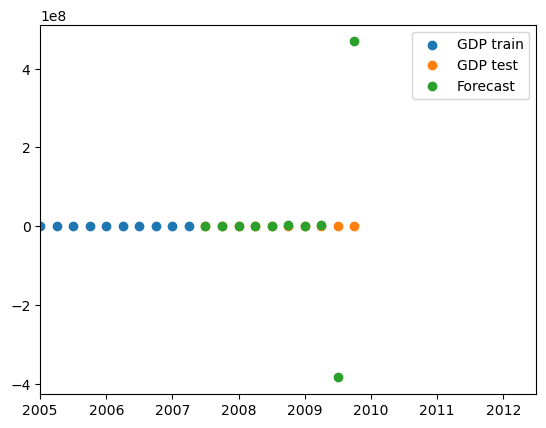

In [156]:
final_forecast = inverse_diff(train_original, df_diff_forecast)

plt.scatter(dataM.date.iloc[train_original.index], train_original['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_original.index], test_original['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast.index], final_forecast['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.xlim(dataM.date.iloc[110],dataM.date.iloc[140])
plt.legend()
plt.show()

#plt.plot(train_original.index, train_original['GDPC1'], label = 'GDP train')
#plt.plot(test_original.index, test_original['GDPC1'], label = 'GDP test')
#plt.plot(final_forecast.index, final_forecast['GDPC1_1st_inv_diff'], label = 'Forecast')
#plt.legend()
#plt.show()



Let's Take another look at this without including the final forecasted GDP value:

I'm not sure what the point of this cell is? It is the same as the above plot - Kerstin

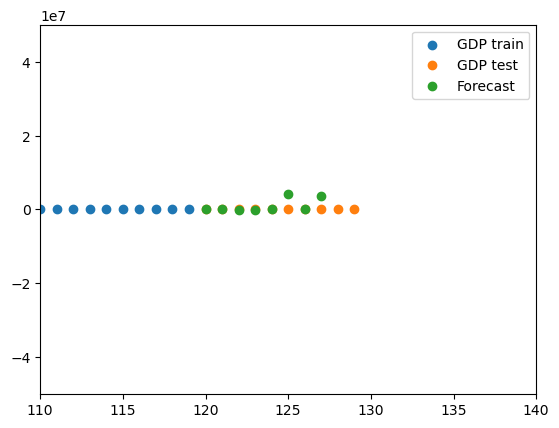

In [157]:
plt.scatter(train_original.index, train_original['GDPC1'], label = 'GDP train')
plt.scatter(test_original.index, test_original['GDPC1'], label = 'GDP test')
plt.scatter(final_forecast.index, final_forecast['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.xlim(110,140)
plt.ylim(-.5e8, .5e8)
plt.legend()
plt.show()

Here we will take another look at the correlation of the vairables. Our forecast does not look to be too accurate after only 3 quarters so we will refine the model some more.

The cointegration test helps to establish the presence of a long run, statistically significant relationship between variables. If no relationship exists then we can't even make a VAR model.

In [158]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

Running a cointegration test on our originl data shows that there is no cointegration between our variables and GDP. When we run it with the differenced data, they are all cointegrated. I'm unclear on how we should look at this test for a few reasons. Cointegration tests are supposed to be in on non-stationary data, and df_original is not completely stationary as seen before so this shouls be fine. But we make the model with our differenced data, so does that mean that we are supposed to be testing that? I think we can proceed with a VAR model with the differenced data with the understanding that the untransformed variables are not cointegrated.

In [159]:
import statsmodels.tsa.stattools as ts
results = []
for col in selected_cols[1:]:
    results.append(ts.coint(df_original.GDPC1, df_original[col])[1])

cointegration = pd.DataFrame()
cointegration["Column"] = selected_cols[1:]
cointegration["P_Value"] = [float(i) for i in results]
#display(cointegration)
cointegration["Cointegrated_with_GDP?"] = cointegration.P_Value < 0.05
cointegration

#coint_johansen(df_original,-1,1).result

,Column,P_Value,Cointegrated_with_GDP?
0,average M trend,0.986317,False
1,average WM trend,0.986317,False
2,average M acceleration,0.966941,False
3,average WM acceleration,0.966941,False
4,sp500 return trend,0.978399,False
5,indu return trend,0.970226,False
6,indu velocity,0.976121,False
7,WPSID62,0.640200,False
8,WPSID62 trend,0.658592,False
9,WPSID62 velocity,0.975509,False


I used vif to look for collinear variables. THere are quite a few here. I believe that the problem lies within the variables that are derived from each other, (e.g. WAB and WAB trend are highly related. But I'm not sure which one to keep based off of just this.)

In [160]:
#vif test for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif_df = pd.DataFrame() 
vif_df["feature"] = df_differenced.columns
vif_df["VIF"] = [variance_inflation_factor(df_differenced.values, i) 
                          for i in range(len(df_differenced.columns))]
vif_df["DW"] = out

c:\Users\Edmund\anaconda3\envs\fin_env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Looking back at the Durbin-Watson results, we can see which variables have serially correlated residuals. The test results are in the range 0-4, with values closest to 2 indicating no serial correlation. I used a combination of these two tests to decide which variables to keep. For example, the VIF results would tell us that WAB velocity and acceleration would be good to keep, but they have very high Durbin-Watson values so they were eliminated. WAB and WAB trend have high VIF values, leanding me to think that they are collinear, so I only kept WAB since it had the lowest DW value. Similar reasoning was used for WPSID62 and T10Y2Y. Avg. MCAP velocity is not collinear with anything, but it has a high DW result. The stock index return trends are highly correlated with each other. I chose to keep indu because of its lower DW. I tested the model with the sp500 and it was not as accurate of a forecast. Including indu velocity results in some crazy behavior so that was eliminated, even though it does not seem to be correlated with the indu return trend.

In [161]:
vif_df

,feature,VIF,DW
0,GDPC1,1.291564,2.197563
1,average M trend,inf,2.159553
2,average WM trend,inf,2.159577
3,average M acceleration,inf,2.245227
4,average WM acceleration,inf,2.245238
5,sp500 return trend,13.613645,2.307417
6,indu return trend,11.013235,2.450595
7,indu velocity,1.245370,2.343966
8,WPSID62,40.074084,2.144164
9,WPSID62 trend,30.615208,2.103594


Below are the selected columns, and a new model built using them.

GDPC1 : 1.91
sp500 return trend : 2.06
WPSID62 : 2.16
WPSID62 velocity : 2.1
WPSID62 acceleration : 2.2
T10Y2Y : 1.94
T10Y2Y trend : 2.1
T10Y2Y velocity : 2.05
WAB trend : 2.07
WAB velocity : 2.07
WAB acceleration : 1.94
average MCAP velocity : 2.09


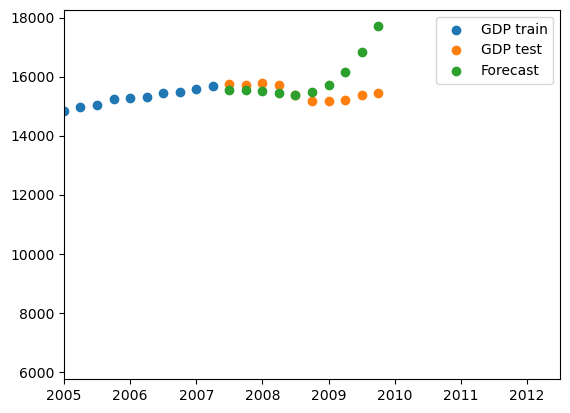

In [166]:
selected_cols_reduce = ['GDPC1',
 'sp500 return trend', 'WPSID62', 'WPSID62 velocity',
 'WPSID62 acceleration',
 'T10Y2Y', 'T10Y2Y trend',
'T10Y2Y velocity',
 'WAB trend', 'WAB velocity', 'WAB acceleration', 'average MCAP velocity']

# selected_cols_reduce = ['GDPC1', 
#  'indu velocity', 'WPSID62 velocity',
#  'T10Y2Y', 'T10Y2Y trend',
# 'T10Y2Y velocity',
#  'WAB acceleration']


df_original_red = df_original[selected_cols_reduce]
df_differenced_red = df_differenced[selected_cols_reduce]

# See what happens when you add back in 'Avg. M-Score'
# df_original_red['Avg. M-Score'] = dataM['Avg. M-Score']
# df_differenced_red['Avg. M-Score'] = dataM_diff['Avg. M-Score']


train_red = df_original_red[:test_start_idx]
test_red = df_original_red[test_start_idx:test_end_idx]
#train1_red = df_differenced_red[test_start_idx-1:test_end_idx-1] # indicies are offset by 1 because dataframe has been differenced

model2 = VAR(train_red)
m2_fitted = model2.fit(5) # order = 6 based on empirical testing and M-Score paper.
lag_order2 = m2_fitted.k_ar # check lag order of model

out2 = durbin_watson(m2_fitted.resid)

for col, val in zip(train_red.columns, out2):
    print('{} : {}'.format(col, round(val, 2)))

# end_idx = idx_2007Q3 + lag_order + more_steps # Just decided to forecast ahead 5 quarters to see what happens.
# forecast_input2 = df_differenced_red.values[test_start_idx-1:test_end_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input2 = df_differenced_red.values[:test_start_idx-1]
# Create the first forecast
# Forecast
fc2 = m2_fitted.forecast(y=forecast_input2, steps=10)
df_diff_forecast2 = pd.DataFrame(fc2, index=df_differenced_red.index[test_start_idx-1:test_end_idx-1], columns=df_differenced_red.columns)
#df_diff_forecast2

final_forecast2 = inverse_diff(train_red, df_diff_forecast2)

# Now let's plot this:
plt.scatter(dataM.date.iloc[train_red.index], train_red['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_red.index], test_red['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast2.index], final_forecast2['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.xlim(dataM.date.iloc[110],dataM.date.iloc[140])
plt.legend()
plt.show()



In [167]:
vif_df2 = pd.DataFrame() 
vif_df2["feature"] = df_differenced_red.columns
vif_df2["VIF"] = [variance_inflation_factor(df_differenced_red.values, i) 
                          for i in range(len(df_differenced_red.columns))]
vif_df2["DW"] = out2
vif_df2

,feature,VIF,DW
0,GDPC1,1.242206,1.910847
1,sp500 return trend,2.797232,2.064466
2,WPSID62,2.335400,2.162903
3,WPSID62 velocity,1.193050,2.103015
4,WPSID62 acceleration,2.214048,2.195854
5,T10Y2Y,2.466512,1.937483
6,T10Y2Y trend,2.620903,2.101209
7,T10Y2Y velocity,1.131936,2.053668
8,WAB trend,1.628342,2.070553
9,WAB velocity,1.234940,2.071626


This forecast looks so much better. We don't have the dramatic increases and decreases of the last one. None of the variables have a VIF > 5 so there is no evidence of multicollinearity. The DW results go from 1.5 to 2.6 but we get our best forecast so I think it is ok.

We wanted to see if we can do some further variable reduction by looking at the cointegration between variables. If two variables are cointegrated, then they have a long running relationship with each other. We are not supposed to use them in VAR models, but we should be able to use the once differenced variables even if they *are* cointegrated. In any case, we can see if the variables that originally have a relationship create a better model.

In [168]:

results2 = []
for col in range(0,11): #selected_cols_reduce[0:]:
    for col2 in range(col+1,11): #selected_cols_reduce[1:]:
        #if col == col2: continue
        results2.append(ts.coint(df_original.loc[:,selected_cols_reduce[col]], df_original.loc[:,selected_cols_reduce[col2]])[1])

cointegration2 = pd.DataFrame(columns=["Column 1", "Column 2"])

coint_col = []
for col in range(0,11): #in selected_cols_reduce[0:]:
    for col2 in range(col+1,11): #in selected_cols_reduce[1:]:
        #if col == col2: continue
        cointegration2.loc[len(cointegration2.index)] = [selected_cols_reduce[col], selected_cols_reduce[col2]]

#cointegration2["Column 1"] = selected_cols_reduce[1:]
cointegration2["P_Value"] = [float(i) for i in results2]
#display(cointegration)
cointegration2["Cointegrated?"] = cointegration2.P_Value < 0.05
cointegration2[cointegration2["Cointegrated?"] == True]

,Column 1,Column 2,P_Value,Cointegrated?
10,sp500 return trend,WPSID62,1.695448e-15,True
11,sp500 return trend,WPSID62 velocity,1.452938e-14,True
12,sp500 return trend,WPSID62 acceleration,1.870583e-14,True
13,sp500 return trend,T10Y2Y,1.471758e-14,True
14,sp500 return trend,T10Y2Y trend,1.623840e-14,True
15,sp500 return trend,T10Y2Y velocity,1.797607e-14,True
16,sp500 return trend,WAB trend,1.530179e-14,True
17,sp500 return trend,WAB velocity,1.517308e-14,True
18,sp500 return trend,WAB acceleration,9.048183e-15,True
27,WPSID62 velocity,WPSID62 acceleration,1.994288e-13,True


Sp500 return trend, PPI velocity and acceleration, yield curve and its velocity, and weighted average beta trend is the set of variables that are all cointegrated with each other. After runnning a few different combinations of variables, the best model actually doesn't include PPI acceleration or the yield curve. THe model is also best when you don't include WAB trend, but I can't tell from this small of a window.

Now making model3 with the differenced cointegrated vairables.

,GDPC1,average M trend,average WM trend,average M acceleration,average WM acceleration,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
0,6313.697,-2.908746,-2.908746,-0.015328,-0.015328,-0.000471,-0.000702,-0.000023,63.7,63.866667,0.05,0.675,0.59,0.627292,-0.005333,0.000188,0.000188,-1099.740210,4.579012e-07,3.254375e-07
1,6333.848,-2.853263,-2.853263,0.005197,0.005197,-0.000529,-0.000693,-0.000069,66.4,66.366667,0.95,-0.100,0.56,0.461208,-0.000979,0.000191,0.000190,-1426.625694,2.057119e-07,-4.117815e-07
2,6578.605,-2.841604,-2.841604,-0.022012,-0.022012,0.001173,0.001397,0.000197,69.8,70.100000,1.85,0.125,0.45,0.399208,-0.003750,0.000191,0.000192,6049.221168,1.685134e-06,3.986992e-07
3,6644.754,-2.820323,-2.820323,0.009112,0.009112,0.000882,0.000848,0.000103,74.6,73.866667,0.70,-0.850,0.14,0.173667,-0.005271,0.000195,0.000195,4570.248510,-1.510248e-07,-7.294480e-07
4,6734.069,-2.862510,-2.862510,0.049223,0.049223,-0.000310,-0.000332,-0.000008,75.1,75.266667,1.65,0.350,-0.14,-0.242833,-0.008437,0.000192,0.000191,-5607.083100,-1.805289e-06,5.702326e-07


,GDPC1,average M trend,average WM trend,average M acceleration,average WM acceleration,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
1,20.151,0.055483,0.055483,0.020525,0.020525,-0.000058,0.000009,-0.000046,2.7,2.500000,0.90,-0.775,-0.03,-0.166083,0.004354,2.634895e-06,2.132972e-06,-326.885484,-2.521892e-07,-7.372190e-07
2,244.757,0.011659,0.011659,-0.027209,-0.027209,0.001702,0.002090,0.000266,3.4,3.733333,0.90,0.225,-0.11,-0.062000,-0.002771,-1.092079e-07,1.345866e-06,7475.846862,1.479422e-06,8.104807e-07
3,66.149,0.021281,0.021281,0.031124,0.031124,-0.000291,-0.000549,-0.000094,4.8,3.766667,-1.15,-0.975,-0.31,-0.225542,-0.001521,3.820992e-06,3.372568e-06,-1478.972657,-1.836159e-06,-1.128147e-06
4,89.315,-0.042188,-0.042188,0.040111,0.040111,-0.001192,-0.001180,-0.000111,0.5,1.400000,0.95,1.200,-0.28,-0.416500,-0.003167,-2.397804e-06,-3.810814e-06,-10177.331610,-1.654264e-06,1.299681e-06
5,12.107,0.111576,0.111576,-0.032847,-0.032847,0.000416,0.000523,0.000137,2.9,3.233333,-0.30,0.425,-0.69,-0.357625,0.004292,6.481692e-07,7.682717e-07,8755.627222,2.812483e-06,-1.087932e-06


GDPC1 : 2.05
sp500 return trend : 1.99
WPSID62 velocity : 2.03
T10Y2Y velocity : 1.87
WAB trend : 1.94


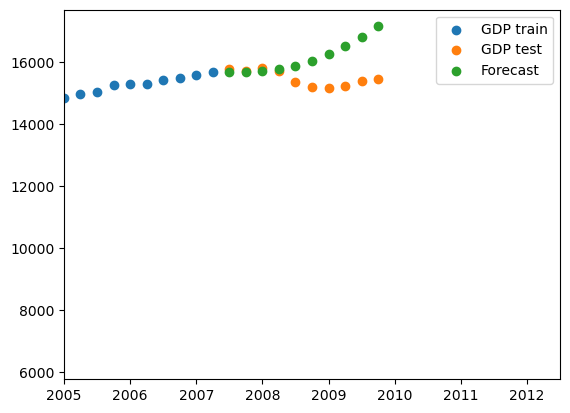

In [169]:
selected_cols_reduce2 = ['GDPC1', 
 'sp500 return trend', 
 'WPSID62 velocity',
 'T10Y2Y velocity', 'WAB trend']

# selected_cols_reduce2 = ['GDPC1',
#  'indu velocity', 'WPSID62 velocity',
#  'T10Y2Y trend',
#  'WAB acceleration']
display(df_original.head())
display(df_differenced.head())
df_original_red2 = df_original[selected_cols_reduce2]
df_differenced_red2 = df_differenced[selected_cols_reduce2]

train_red2 = df_original_red2[:test_start_idx]
test_red2 = df_original_red2[test_start_idx:test_end_idx]
#train1_red2 = df_differenced_red2[test_start_idx-1:test_end_idx-1] # indicies are offset by 1 because dataframe has been differenced

model3 = VAR(train_red2)
m3_fitted = model3.fit(5) # order = 6 based on empirical testing and M-Score paper.
lag_order3 = m3_fitted.k_ar # check lag order of model

out3 = durbin_watson(m3_fitted.resid)

for col, val in zip(train_red2.columns, out3):
    print('{} : {}'.format(col, round(val, 2)))

# end_idx = idx_2007Q3 + lag_order + more_steps # Just decided to forecast ahead 5 quarters to see what happens.
# forecast_input3 = df_differenced_red2.values[test_start_idx-1:test_end_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input3 = df_differenced_red2.values[:test_start_idx-1]
# Create the first forecast
# Forecast
fc3 = m3_fitted.forecast(y=forecast_input3, steps=10)
df_diff_forecast3 = pd.DataFrame(fc3, index=df_differenced_red2.index[test_start_idx-1:test_end_idx-1], columns=df_differenced_red2.columns)
#df_diff_forecast2

final_forecast3 = inverse_diff(train_red2, df_diff_forecast3)

# Now let's plot this:
plt.scatter(dataM.date.iloc[train_red2.index], train_red2['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_red2.index], test_red2['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast3.index], final_forecast3['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.xlim(dataM.date.iloc[110],dataM.date.iloc[140])
plt.legend()
plt.show()


In [170]:
vif_df3 = pd.DataFrame() 
vif_df3["feature"] = df_differenced_red2.columns
vif_df3["VIF"] = [variance_inflation_factor(df_differenced_red2.values, i) 
                          for i in range(len(df_differenced_red2.columns))]
vif_df3["DW"] = out3
vif_df3

,feature,VIF,DW
0,GDPC1,1.030132,2.054719
1,sp500 return trend,1.145780,1.988994
2,WPSID62 velocity,1.009449,2.034686
3,T10Y2Y velocity,1.023393,1.868806
4,WAB trend,1.151089,1.936386


In [171]:
# Calculate mean squared error from these two values
# Forcast - Actual = Mean Squared Error 

from statsmodels.tsa.stattools import acf


def forecast_accuracy(forcast, actual):
    #rsfe = np.
    mse = np.mean((forcast - actual)**2)
    rmse = np.sqrt(mse)
    corr = np.corrcoef(forcast, actual)[0,1]

    return({'Mean Squared Error':mse, 'Root Mean Squared Error':rmse, 'Correlation Coefficient':corr})

print(' Forcast Accuracy of: final_forcast')
# accuracy_prob = forecast_accuracy(final_forecast['GDPC1_1st_inv_diff'][:-3], test_original['GDPC1'][1:])
accuracy_prob = forecast_accuracy(final_forecast['GDPC1_1st_inv_diff'], test_original['GDPC1'])
for k, v in accuracy_prob.items():
    print(k, ':', v)

# model 1
# test_original['GDPC1'] 
# final_forecast['GDPC1_1st_inv_diff']

print('\n Forcast Accuracy of: final_forcast2')
accuracy_prob = forecast_accuracy(final_forecast2['GDPC1_1st_inv_diff'], test_red['GDPC1'])
for k, v in accuracy_prob.items():
    print(k, ':', v)

print('\n Forcast Accuracy of: final_forcast3')
accuracy_prob = forecast_accuracy(final_forecast3['GDPC1_1st_inv_diff'], test_red2['GDPC1'])
for k, v in accuracy_prob.items():
    print(k, ':', v)

# # model 2
# test_original_red['GDPC1'] 
# final_forecast2['GDPC1_1st_inv_diff']



 Forcast Accuracy of: final_forcast
Mean Squared Error : 3.672393745971854e+16
Root Mean Squared Error : 191634906.68382558
Correlation Coefficient : 0.05672915850541989

 Forcast Accuracy of: final_forcast2
Mean Squared Error : 862816.3626468402
Root Mean Squared Error : 928.8790893581577
Correlation Coefficient : -0.20830591258328518

 Forcast Accuracy of: final_forcast3
Mean Squared Error : 875050.0849408063
Root Mean Squared Error : 935.4411178373582
Correlation Coefficient : -0.5338218905061878


Model2 is by far the most accurate at predicting the beginning and end of the 2008 great recession. Next we will see how good model2 is at predicting earlier recessions. Finally, I may use a varient of model2 to predict GDP changes beyond 2023.

### Printing Durbin Watson Statistics for models 2A, 2B, and 2C: ###
#### DW statistics for model 2A ####
GDPC1 : 1.91
sp500 return trend : 2.34
WPSID62 : 1.71
WPSID62 velocity : 2.02
WPSID62 acceleration : 1.72
T10Y2Y : 2.03
T10Y2Y trend : 2.26
T10Y2Y velocity : 2.27
WAB trend : 2.05
WAB velocity : 1.98
WAB acceleration : 2.05
average MCAP velocity : 2.24
#### DW statistics for model 2B ####
GDPC1 : 2.74
sp500 return trend : 1.93
WPSID62 : 1.51
WPSID62 velocity : 1.78
WPSID62 acceleration : 2.68
T10Y2Y : 2.08
T10Y2Y trend : 1.68
T10Y2Y velocity : 2.06
WAB trend : 2.28
WAB velocity : 1.94
WAB acceleration : 2.25
average MCAP velocity : 2.34
#### DW statistics for model 2C ####
GDPC1 : 0.21
sp500 return trend : 1.93
WPSID62 : 0.5
WPSID62 velocity : 1.3
WPSID62 acceleration : 0.88
T10Y2Y : 1.23
T10Y2Y trend : 1.15
T10Y2Y velocity : 0.2
WAB trend : 0.15
WAB velocity : 1.09
WAB acceleration : 1.13
average MCAP velocity : 1.13


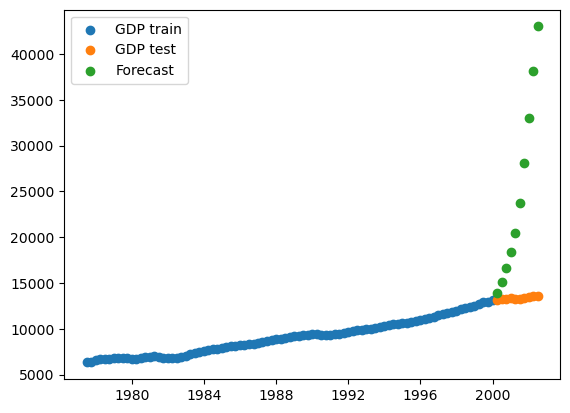

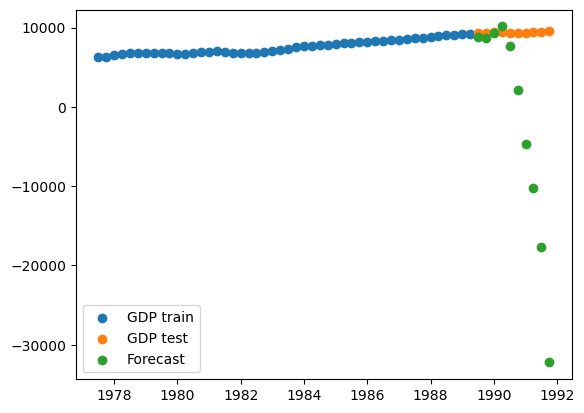

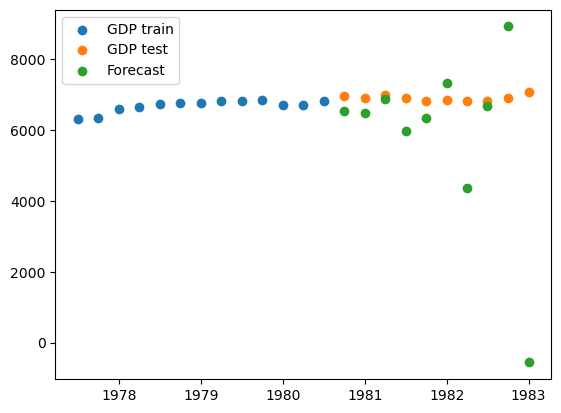

In [172]:
'''
Recession A, approx date range: (2001 Q2 - 2001 Q4), date range for model2A: (2000 Q2 - 2002 Q4)
Recession B: approx date range: (1990 Q3 - 1991 Q2), date range for model2A: (1989 Q3 - 1992 Q1)
Recession C: approx date range: (1981 Q3 - 1982 Q4), date range for model2A: (1980 Q4 - 1983 Q2)

Next recession: ???
'''

# Create test periods that cover different recessions (A, B, C)
start_A_idx = dataM.index[dataM['Quarter'] == '2000Q2'][0] # Identify the starting index for the test and forecast data
end_A_idx = dataM.index[dataM['Quarter'] == '2002Q4'][0] # Identify the final index of the test and forecast data

start_B_idx = dataM.index[dataM['Quarter'] == '1989Q3'][0] # Identify the starting index for the test and forecast data
end_B_idx = dataM.index[dataM['Quarter'] == '1992Q1'][0] # Identify the final index of the test and forecast data

start_C_idx = dataM.index[dataM['Quarter'] == '1980Q4'][0] # Identify the starting index for the test and forecast data
end_C_idx = dataM.index[dataM['Quarter'] == '1983Q2'][0] # Identify the final index of the test and forecast data

# df_original_red and df_differeneced_red come from model2
train_A = df_original_red[:start_A_idx]
test_A = df_original_red[start_A_idx:end_A_idx]
train_B = df_original_red[:start_B_idx]
test_B = df_original_red[start_B_idx:end_B_idx]
train_C = df_original_red[:start_C_idx]
test_C = df_original_red[start_C_idx:end_C_idx]

# Create the VAR models
model2A = VAR(train_A)
m2A_fitted = model2A.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order2A = m2A_fitted.k_ar # check lag order of model

model2B = VAR(train_B)
m2B_fitted = model2B.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order2B = m2B_fitted.k_ar # check lag order of model

model2C = VAR(train_C)
m2C_fitted = model2C.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order2C = m2C_fitted.k_ar # check lag order of model

# Generate Durbin Watson statistics
out2A = durbin_watson(m2A_fitted.resid)
out2B = durbin_watson(m2B_fitted.resid)
out2C = durbin_watson(m2C_fitted.resid)

print('### Printing Durbin Watson Statistics for models 2A, 2B, and 2C: ###')
print('#### DW statistics for model 2A ####')
for col, val in zip(train_A.columns, out2A):
    print('{} : {}'.format(col, round(val, 2)))
print('#### DW statistics for model 2B ####')
for col, val in zip(train_B.columns, out2B):
    print('{} : {}'.format(col, round(val, 2)))
print('#### DW statistics for model 2C ####')
for col, val in zip(train_C.columns, out2C):
    print('{} : {}'.format(col, round(val, 2)))

# Create forecast input values for models A, B, and C
# forecast_input2A = df_differenced_red.values[start_A_idx-1:end_A_idx-1] # indicies are offset by 1 because dataframe has been differenced
# forecast_input2B = df_differenced_red.values[start_B_idx-1:end_B_idx-1] # indicies are offset by 1 because dataframe has been differenced
# forecast_input2C = df_differenced_red.values[start_C_idx-1:end_C_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input2A = df_differenced_red.values[:start_A_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input2B = df_differenced_red.values[:start_B_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input2C = df_differenced_red.values[:start_C_idx-1] # indicies are offset by 1 because dataframe has been differenced

# Generate forecasts for models A, B, and C
fc2A = m2A_fitted.forecast(y=forecast_input2A, steps=10)
fc2B = m2B_fitted.forecast(y=forecast_input2B, steps=10)
fc2C = m2C_fitted.forecast(y=forecast_input2C, steps=10)

# get pandas dataframes for the forecasts of differenced data
df_diff_forecast2A = pd.DataFrame(fc2A, index=df_differenced_red.index[start_A_idx-1:end_A_idx-1], columns=df_differenced_red.columns)
df_diff_forecast2B = pd.DataFrame(fc2B, index=df_differenced_red.index[start_B_idx-1:end_B_idx-1], columns=df_differenced_red.columns)
df_diff_forecast2C = pd.DataFrame(fc2C, index=df_differenced_red.index[start_C_idx-1:end_C_idx-1], columns=df_differenced_red.columns)

# transform the differenced data to get the real forecast data
final_forecast2A = inverse_diff(train_A, df_diff_forecast2A)
final_forecast2B = inverse_diff(train_B, df_diff_forecast2B)
final_forecast2C = inverse_diff(train_C, df_diff_forecast2C)

# Plot model 2A forecast
plt.scatter(dataM.date.iloc[train_A.index], train_A['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_A.index], test_A['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast2A.index], final_forecast2A['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

# Plot model 2B forecast
plt.scatter(dataM.date.iloc[train_B.index], train_B['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_B.index], test_B['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast2B.index], final_forecast2B['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

# Plot model 2C forecast
plt.scatter(dataM.date.iloc[train_C.index], train_C['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_C.index], test_C['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast2C.index], final_forecast2C['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

Model2 is not good at forecasting recessions earlier than the 2008 great recession. Is this because we don't have enough training data? Or is something else wrong with the model? Next I will try to forecast past recessions with model3

### Printing Durbin Watson Statistics for models 3A, 3B, and 3C: ###
#### DW statistics for model 3A ####
GDPC1 : 1.97
sp500 return trend : 2.04
WPSID62 velocity : 2.2
T10Y2Y velocity : 1.83
WAB trend : 1.84
#### DW statistics for model 3B ####
GDPC1 : 1.74
sp500 return trend : 2.16
WPSID62 velocity : 1.62
T10Y2Y velocity : 1.98
WAB trend : 1.68
#### DW statistics for model 3C ####
GDPC1 : 0.25
sp500 return trend : 1.21
WPSID62 velocity : 0.88
T10Y2Y velocity : 0.71
WAB trend : 0.66


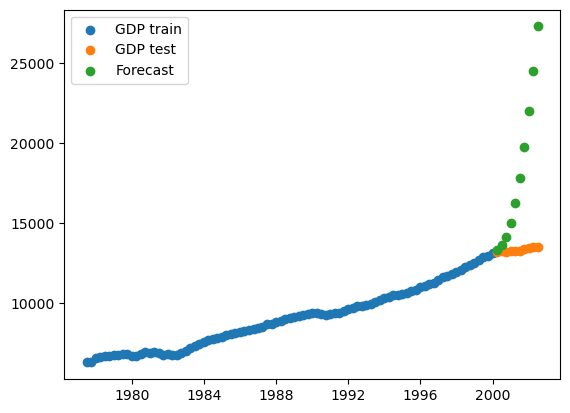

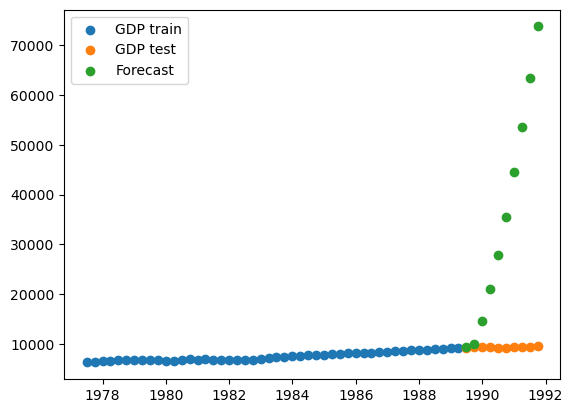

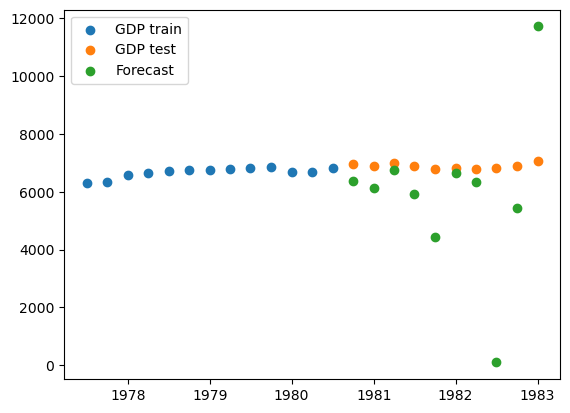

In [173]:
# trying to predict earlier recessions with model3
'''
Recession A, approx date range: (2001 Q2 - 2001 Q4), date range for model2A: (2000 Q2 - 2002 Q4)
Recession B: approx date range: (1990 Q3 - 1991 Q2), date range for model2A: (1989 Q3 - 1992 Q1)
Recession C: approx date range: (1981 Q3 - 1982 Q4), date range for model2A: (1980 Q4 - 1983 Q2)

Next recession: ???
'''

# Create test periods that cover different recessions (A, B, C)
start_A_idx = dataM.index[dataM['Quarter'] == '2000Q2'][0] # Identify the starting index for the test and forecast data
end_A_idx = dataM.index[dataM['Quarter'] == '2002Q4'][0] # Identify the final index of the test and forecast data

start_B_idx = dataM.index[dataM['Quarter'] == '1989Q3'][0] # Identify the starting index for the test and forecast data
end_B_idx = dataM.index[dataM['Quarter'] == '1992Q1'][0] # Identify the final index of the test and forecast data

start_C_idx = dataM.index[dataM['Quarter'] == '1980Q4'][0] # Identify the starting index for the test and forecast data
end_C_idx = dataM.index[dataM['Quarter'] == '1983Q2'][0] # Identify the final index of the test and forecast data

# df_original_red2 and df_differeneced_red2 come from model3
train_A = df_original_red2[:start_A_idx]
test_A = df_original_red2[start_A_idx:end_A_idx]
train_B = df_original_red2[:start_B_idx]
test_B = df_original_red2[start_B_idx:end_B_idx]
train_C = df_original_red2[:start_C_idx]
test_C = df_original_red2[start_C_idx:end_C_idx]

# Create the VAR models
model3A = VAR(train_A)
m3A_fitted = model3A.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order3A = m3A_fitted.k_ar # check lag order of model

model3B = VAR(train_B)
m3B_fitted = model3B.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order3B = m3B_fitted.k_ar # check lag order of model

model3C = VAR(train_C)
m3C_fitted = model3C.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order3C = m3C_fitted.k_ar # check lag order of model

# Generate Durbin Watson statistics
out3A = durbin_watson(m3A_fitted.resid)
out3B = durbin_watson(m3B_fitted.resid)
out3C = durbin_watson(m3C_fitted.resid)

print('### Printing Durbin Watson Statistics for models 3A, 3B, and 3C: ###')
print('#### DW statistics for model 3A ####')
for col, val in zip(train_A.columns, out3A):
    print('{} : {}'.format(col, round(val, 2)))
print('#### DW statistics for model 3B ####')
for col, val in zip(train_B.columns, out3B):
    print('{} : {}'.format(col, round(val, 2)))
print('#### DW statistics for model 3C ####')
for col, val in zip(train_C.columns, out3C):
    print('{} : {}'.format(col, round(val, 2)))

# Create forecast input values for models A, B, and C
# forecast_input3A = df_differenced_red2.values[start_A_idx-1:end_A_idx-1] # indicies are offset by 1 because dataframe has been differenced
# forecast_input3B = df_differenced_red2.values[start_B_idx-1:end_B_idx-1] # indicies are offset by 1 because dataframe has been differenced
# forecast_input3C = df_differenced_red2.values[start_C_idx-1:end_C_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input3A = df_differenced_red2.values[:start_A_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input3B = df_differenced_red2.values[:start_B_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input3C = df_differenced_red2.values[:start_C_idx-1] # indicies are offset by 1 because dataframe has been differenced

# Generate forecasts for models A, B, and C
fc3A = m3A_fitted.forecast(y=forecast_input3A, steps=10)
fc3B = m3B_fitted.forecast(y=forecast_input3B, steps=10)
fc3C = m3C_fitted.forecast(y=forecast_input3C, steps=10)

# get pandas dataframes for the forecasts of differenced data
df_diff_forecast3A = pd.DataFrame(fc3A, index=df_differenced_red2.index[start_A_idx-1:end_A_idx-1], columns=df_differenced_red2.columns)
df_diff_forecast3B = pd.DataFrame(fc3B, index=df_differenced_red2.index[start_B_idx-1:end_B_idx-1], columns=df_differenced_red2.columns)
df_diff_forecast3C = pd.DataFrame(fc3C, index=df_differenced_red2.index[start_C_idx-1:end_C_idx-1], columns=df_differenced_red2.columns)

# transform the differenced data to get the real forecast data
final_forecast3A = inverse_diff(train_A, df_diff_forecast3A)
final_forecast3B = inverse_diff(train_B, df_diff_forecast3B)
final_forecast3C = inverse_diff(train_C, df_diff_forecast3C)

# Plot model 3A forecast
plt.scatter(dataM.date.iloc[train_A.index], train_A['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_A.index], test_A['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast3A.index], final_forecast3A['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

# Plot model 3B forecast
plt.scatter(dataM.date.iloc[train_B.index], train_B['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_B.index], test_B['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast3B.index], final_forecast3B['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

# Plot model 3C forecast
plt.scatter(dataM.date.iloc[train_C.index], train_C['GDPC1'], label = 'GDP train')
plt.scatter(dataM.date.iloc[test_C.index], test_C['GDPC1'], label = 'GDP test')
plt.scatter(dataM.date.iloc[final_forecast3C.index], final_forecast3C['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

Model3 is also bad at predicting recessions before 2008. Maybe there is not enough training data to use our model to forecast past recessions?
Next I will make model4 which uses the dataset that runs to 2023, but does not include weighted average beta or M-score. I will include model2 variables that are part of this data set then try to predict the late 2000 recession, the 2008 recession, the 2020 covid mini recession, and forecast what may be coming in the future. 

### Printing Durbin Watson Statistics for models 4A, 4D, 4E and 4F: ###
#### DW statistics for model 4A ####
GDPC1 : 2.07
sp500 return trend : 2.2
WPSID62 velocity : 2.06
T10Y2Y velocity : 2.17
WAB trend : 2.04
#### DW statistics for model 4D ####
GDPC1 : 2.02
sp500 return trend : 2.06
WPSID62 velocity : 2.31
T10Y2Y velocity : 2.17
WAB trend : 2.23
#### DW statistics for model 4E ####
GDPC1 : 2.01
sp500 return trend : 2.04
WPSID62 velocity : 2.03
T10Y2Y velocity : 2.05
WAB trend : 2.01
#### DW statistics for model 4F ####
GDPC1 : 2.01
sp500 return trend : 2.06
WPSID62 velocity : 2.01
T10Y2Y velocity : 2.0
WAB trend : 2.03


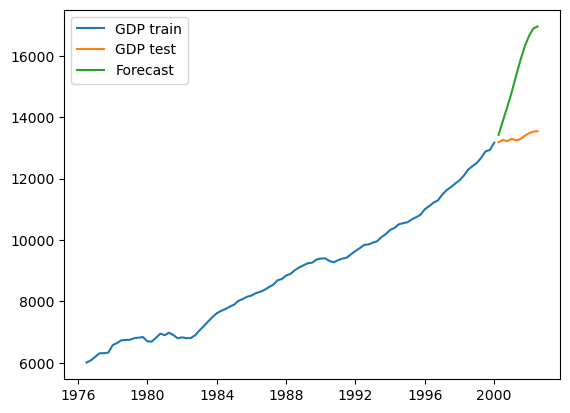

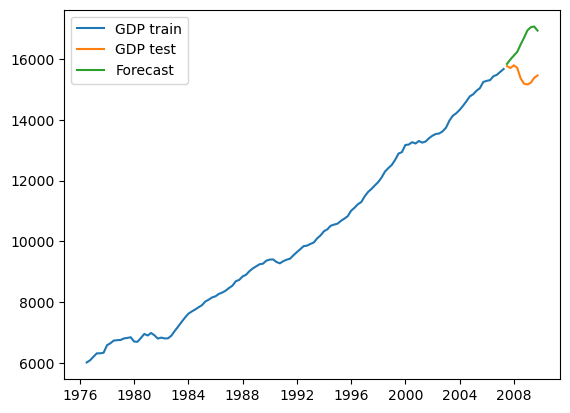

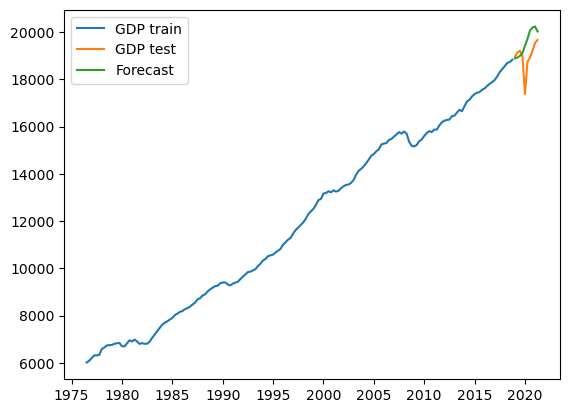

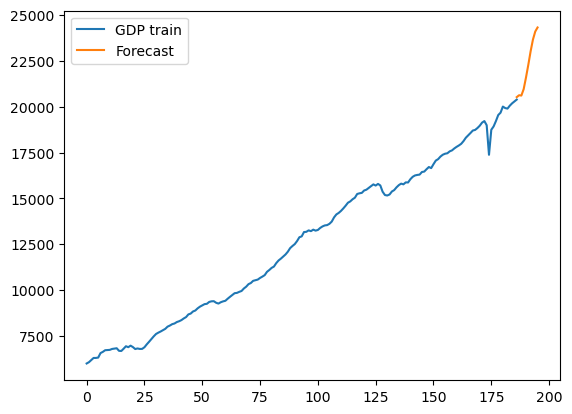

In [175]:
# model 4: Trying to predict modern and future recession with a longer range data set
'''
Recession A, date range for model2A: (2000 Q2 - 2002 Q4)
Recession D: date range for model2D: (2007 Q3 - 2010 Q1)
Recession E: date range for model2E: (2019 Q1 - 2021 Q3)
GDP F: date range for modelF: (2023 Q2 - 2025 Q4)

'''

# model4 vars same as model2 except WAB and MCAP related variables removed (because they are not part of this dataset):
selected_cols_4 = ['GDPC1',
 'sp500 return trend', 'WPSID62', 'WPSID62 velocity',
 'WPSID62 acceleration',
 'T10Y2Y', 'T10Y2Y trend',
'T10Y2Y velocity']

# Create original and differenced dataframes with selected columns for model4
df_original_m4 = data[selected_cols_4]
df_differenced_m4 = data_diff[selected_cols_4]

# Create test periods that cover different recessions (A, B, C)
start_A4_idx = data.index[data['Quarter'] == '2000Q2'][0] # Identify the starting index for the test and forecast data
end_A4_idx = data.index[data['Quarter'] == '2002Q4'][0] # Identify the final index of the test and forecast data

start_D4_idx = data.index[data['Quarter'] == '2007Q3'][0] # Identify the starting index for the test and forecast data
end_D4_idx = data.index[data['Quarter'] == '2010Q1'][0] # Identify the final index of the test and forecast data

start_E4_idx = data.index[data['Quarter'] == '2019Q1'][0] # Identify the starting index for the test and forecast data
end_E4_idx = data.index[data['Quarter'] == '2021Q3'][0] # Identify the final index of the test and forecast data

# The index here doesn't actually exist!!
start_F4_idx = data.index[data['Quarter'] == '2023Q1'][0] # Identify the starting index for the test and forecast data
# end_F4_idx = data.index[data['Quarter'] == '2025Q4'][0] # Identify the final index of the test and forecast data

# df_original_red2 and df_differeneced_red2 come from model3
train_A4 = df_original_m4[:start_A4_idx]
test_A4 = df_original_m4[start_A4_idx:end_A4_idx]
train_D4 = df_original_m4[:start_D4_idx]
test_D4 = df_original_m4[start_D4_idx:end_D4_idx]
train_E4 = df_original_m4[:start_E4_idx]
test_E4 = df_original_m4[start_E4_idx:end_E4_idx]
train_F4 = df_original_m4[:] # Use all the data as training data to forecast into the future
#test_F4 = df_original_m4[start_F4_idx:end_F4_idx]

# Create the VAR models
model4A = VAR(train_A4)
m4A_fitted = model4A.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order4A = m4A_fitted.k_ar # check lag order of model

model4D = VAR(train_D4)
m4D_fitted = model4D.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order4D = m4D_fitted.k_ar # check lag order of model

model4E = VAR(train_E4)
m4E_fitted = model4E.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order4E = m4E_fitted.k_ar # check lag order of model

model4F = VAR(train_F4)
m4F_fitted = model4F.fit(5) # order = 5 based on empirical testing and M-Score paper.
lag_order4F = m4F_fitted.k_ar # check lag order of model

# Generate Durbin Watson statistics
out4A = durbin_watson(m4A_fitted.resid)
out4D = durbin_watson(m4D_fitted.resid)
out4E = durbin_watson(m4E_fitted.resid)
out4F = durbin_watson(m4F_fitted.resid)

print('### Printing Durbin Watson Statistics for models 4A, 4D, 4E and 4F: ###')
print('#### DW statistics for model 4A ####')
for col, val in zip(train_A.columns, out4A):
    print('{} : {}'.format(col, round(val, 2)))
print('#### DW statistics for model 4D ####')
for col, val in zip(train_B.columns, out4D):
    print('{} : {}'.format(col, round(val, 2)))
print('#### DW statistics for model 4E ####')
for col, val in zip(train_C.columns, out4E):
    print('{} : {}'.format(col, round(val, 2)))
print('#### DW statistics for model 4F ####')
for col, val in zip(train_C.columns, out4F):
    print('{} : {}'.format(col, round(val, 2)))

# Create forecast input values for models A, B, and C
# forecast_input4A = df_differenced_m4.values[start_A4_idx-1:end_A4_idx-1] # indicies are offset by 1 because dataframe has been differenced
# forecast_input4D = df_differenced_m4.values[start_D4_idx-1:end_D4_idx-1] # indicies are offset by 1 because dataframe has been differenced
# forecast_input4E = df_differenced_m4.values[start_E4_idx-1:end_E4_idx-1] # indicies are offset by 1 because dataframe has been differenced
# forecast_input4F = df_differenced_m4.values[start_F4_idx-1:end_F4_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input4A = df_differenced_m4.values[:start_A4_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input4D = df_differenced_m4.values[:start_D4_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input4E = df_differenced_m4.values[:start_E4_idx-1] # indicies are offset by 1 because dataframe has been differenced
forecast_input4F = df_differenced_m4.values[:start_F4_idx-1] # indicies are offset by 1 because dataframe has been differenced

# Generate forecasts for models A, B, and C
fc4A = m4A_fitted.forecast(y=forecast_input4A, steps=10)
fc4D = m4A_fitted.forecast(y=forecast_input4D, steps=10)
fc4E = m4A_fitted.forecast(y=forecast_input4E, steps=10)
fc4F = m4A_fitted.forecast(y=forecast_input4F, steps=10)

# get pandas dataframes for the forecasts of differenced data
df_diff_forecast4A = pd.DataFrame(fc4A, index=df_differenced_m4.index[start_A4_idx-1:end_A4_idx-1], columns=df_differenced_m4.columns)
df_diff_forecast4D = pd.DataFrame(fc4D, index=df_differenced_m4.index[start_D4_idx-1:end_D4_idx-1], columns=df_differenced_m4.columns)
df_diff_forecast4E = pd.DataFrame(fc4E, index=df_differenced_m4.index[start_E4_idx-1:end_E4_idx-1], columns=df_differenced_m4.columns)
df_diff_forecast4F = pd.DataFrame(fc4F, index=range(start_F4_idx,start_F4_idx+10), columns=df_differenced_m4.columns) # see If I can use a range going into the future

# transform the differenced data to get the real forecast data
final_forecast4A = inverse_diff(train_A4, df_diff_forecast4A)
final_forecast4D = inverse_diff(train_D4, df_diff_forecast4D)
final_forecast4E = inverse_diff(train_E4, df_diff_forecast4E)
final_forecast4F = inverse_diff(train_F4, df_diff_forecast4F)

# Plot model 4A forecast
plt.plot(data.date.iloc[train_A4.index], train_A4['GDPC1'], label = 'GDP train')
plt.plot(data.date.iloc[test_A4.index], test_A4['GDPC1'], label = 'GDP test')
plt.plot(data.date.iloc[final_forecast4A.index], final_forecast4A['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

# Plot model 4D forecast
plt.plot(data.date.iloc[train_D4.index], train_D4['GDPC1'], label = 'GDP train')
plt.plot(data.date.iloc[test_D4.index], test_D4['GDPC1'], label = 'GDP test')
plt.plot(data.date.iloc[final_forecast4D.index], final_forecast4D['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

# Plot model 4E forecast
plt.plot(data.date.iloc[train_E4.index], train_E4['GDPC1'], label = 'GDP train')
plt.plot(data.date.iloc[test_E4.index], test_E4['GDPC1'], label = 'GDP test')
plt.plot(data.date.iloc[final_forecast4E.index], final_forecast4E['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

# Plot model 4F forecast
plt.plot(train_F4.index, train_F4['GDPC1'], label = 'GDP train')
#plt.scatter(data.date.iloc[test_F4.index], test_F4['GDPC1'], label = 'GDP test')
plt.plot(final_forecast4F.index, final_forecast4F['GDPC1_1st_inv_diff'], label = 'Forecast')
plt.legend()
plt.show()

In [ ]:
selected_cols_reduce

Based off of the Mean Squared Errors, it looks like model2 is the best one. According to its RMSE, the predicted GDP is off by $181 billion on average. This may seem like a lot but the US' GDP at the end of 2013 was $16.84 trillion, or  $16,840 billion. This model uses the differenced S&P 500 return trend, PPI, PPI velocity, PPI acceleration, Yield Curve, Yield Curve velocity, Yield Curve trend, Weighted Average Beta velocity, Weighted Average Beta acceleration, average MCAP velocity, and Weighted Average Beta trend to predict GDP with a 5 quarter lag.

There is a significant difference between the MSE's between model2 and model3. Model2 is mathematically the best model, but if we are worried about overfitting then model3 is also a good option. They are both much better than model1.


In [ ]:
quarters = dataM['Quarter']

In [ ]:
final_forecast['GDPC1_1st_inv_diff']

In [ ]:
final_forecast.join(quarters)
final_forecast2.join(quarters)
final_forecast3.join(quarters)
test_original.join(quarters)
test_red.join(quarters)
test_red2.join(quarters)


**The code below creates recession indicators for the original data. We need it for the forecast too!!**

In [ ]:
# The code below manually calculates the periods of recession and creates a new column of Boolean values called "Final_Recession" where
# '1' = Recession and '0' = No Recession. This code uses the definition of recession as follows: Recession starts after two consecutive quarters 
# of decline in GDP, and ends after two consecutive quarters of growth in GDP. This code counts recessions for up to six quartes in length. 

# Copy dataM
recession = dataM.copy()

# Shift the Gdpc1 to calculate the difference in GDP
recession['Gdpc1_shift'] = recession.GDPC1.shift(1).ffill()

# Calculate GDP difference
recession['GDP_Diff'] = recession.GDPC1.sub(recession.Gdpc1_shift) 

# Create column of values with +1 for growth and -1 for decline
recession['Recession_Sign'] = np.sign(recession['GDP_Diff'])

# Create colum of values that note the start of a recession with 1
recession['Recession_start'] = np.where((recession['Recession_Sign'].shift(1) + recession['Recession_Sign'])<0, 1, 0)

# Since a recession will last at least 3 quarters, I now shift the recession start by 2 to mark an ongoing recession
recession['Second_Quarter'] = recession['Recession_start'].shift(1)
recession['Third_Quarter'] = recession['Recession_start'].shift(2)

# Create new column of '1' and '0' by combinging the first three quarters of a recession, '1' = Recession, '0'= No Recession
recession['Recession_1'] = np.where((recession['Recession_start'] + recession['Second_Quarter'] + recession['Third_Quarter']) >=1,1,0)

# Next, we determine if the recession ended by two consecutive quaquarters of growth
recession['recession_end_1'] = np.where((recession['Recession_Sign'].shift(2)==1) & (recession['Recession_Sign'].shift(1)==1), 0, 1)

# Create new column of '1' and '0' by combinging Recession_1 and recession_end_1 where '1' = Recession, '0'= No Recession
recession['Recession_2'] = np.where((recession['Recession_1']==1) & (recession['recession_end_1']==1), 1, 0)

# Check if the recession conties into the 4th quarter 
recession['Forth_Quarter'] = np.where((recession['Recession_2'].shift(1)==1) & (recession['recession_end_1']==1) , 1, 0)

# Check if the recession conties into the 5th quarter 
recession['Fifth_Quarter'] = np.where((recession['Forth_Quarter'].shift(1)==1) & (recession['recession_end_1']==1) , 1, 0)

# Check if the recession conties into the 6th quarter 
recession['Sixth_Quarter'] = np.where((recession['Fifth_Quarter'].shift(1)==1) & (recession['recession_end_1']==1) , 1, 0)

# Create new column of '1' and '0' by combinging Recession_2, Forth_Quarter, Fifth_Quarter, Sixth_Quarter where '1' = Recession, '0'= No Recession
recession['Final_Recession'] = np.where((recession['Recession_2'] + recession['Fifth_Quarter'] + recession['Fifth_Quarter'] + recession['Sixth_Quarter'] >=1) , 1, 0)

# Clean up dataframe to only include relevant values to the recession calculation 
recession.drop(recession.columns.difference(['Quarter','GDPC1','Gdpc1_shift','GDP_Diff','Recession_Sign','Recession_start','Recession_end_test','Second_Quarter','Third_Quarter',
                                             'Recession_1','recession_end_1','Recession_2','Forth_Quarter','Fifth_Quarter','Sixth_Quarter','Final_Recession']), 1, inplace=True)

In [ ]:
recession.head()

In [ ]:
# Ok. Time to export both of these to csv:
from datetime import datetime
now = datetime.now()
date_str = str(now.year) + str(now.month) + str(now.day) + str(now.hour) + str(now.minute) + str(now.second)
#print(date_str)

#I'm commenting the output_dir our so the cell throws an error so that we aren't continuously creating new csv files henever we run the notebook
# output_dir = r"C:\\Users\\Edmund\\OMSA\\MGT6203\\group project\Team36_group_project\Data\\"
#output_dir = "/Users/lukaszsledz/Documents/GaTech/MGT_6203/Project/Team-36/Data/"

fname1 = output_dir + "test_original"  + date_str + '.csv'
test_original.to_csv(fname1, index=False)
fname2 = output_dir + "test_oroginal_red"  + date_str + '.csv'
test_original_red.to_csv(fname2, index=False)

fname1 = output_dir + "final_forecast"  + date_str + '.csv'
final_forecast.to_csv(fname1, index=False)
fname2 = output_dir + "final_forecast2"  + date_str + '.csv'
final_forecast2.to_csv(fname2, index=False)

fname1 = output_dir + "recession"  + date_str + '.csv'
recession.to_csv(fname1, index=False)
